In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from math import pi

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import ones, zeros, eye, as_tensor, tensor, float32
from torch.distributions import MultivariateNormal, Exponential

from sbi.inference import NPE
from sbi.analysis import pairplot
from sbi.utils import BoxUniform, MultipleIndependent

from paper.colors import colors

/Users/michaeldeistler/anaconda3/envs/sbitutorial/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
plt.rcParams['svg.fonttype'] = 'none'

In [4]:
def simulate(angle, strength, wind):
    xs = [0.0]
    ys = [0.0]

    angle = angle / 180 * pi

    dx = np.cos(angle) * strength
    dy = np.sqrt(strength**2 - dx**2)
    
    for i in range(10_000):
        x, y, dx, dy = step(xs[-1], ys[-1], dx, dy, dt, angle, strength, wind)
        xs.append(x)
        ys.append(y)
        if i > 1 and ys[-1] < 0:
            break
    return xs, ys

def step(x, y, dx, dy, dt, angle, strength, wind):
    gravity = 0.05
    friction_x = friction * dx
    friction_y = friction * dy

    ddy = -gravity - friction_y
    dy += ddy * dt

    ddx = wind - friction_x
    dx += ddx * dt

    return x + dx * dt, y + dy * dt, dx, dy

def throw_distance(xs, ys):
    frac = 1 - (ys[-1] / (ys[-1] - ys[-2]))
    return frac * (xs[-1] - xs[-2]) + xs[-2] + np.random.rand() * 0.1

In [5]:
angle = 45
strength = 0.7
friction = 0.01
dt = 0.5

In [6]:
all_xs = []
all_ys = []
dists = []

for wind in [0.0, 0.01, 0.03]:
    xs, ys = simulate(angle, strength, wind)
    all_xs.append(xs)
    all_ys.append(ys)
    dist = throw_distance(xs, ys)
    dists.append(dist)

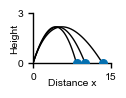

In [7]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1., 0.65))
    for xs, ys in zip(all_xs, all_ys):
        _ = ax.plot(xs, ys, c="k")
    _ = ax.set_xlim([0, 15])
    _ = ax.set_xticks([0, 15])
    _ = ax.set_ylim([0, 3])
    _ = ax.set_yticks([0, 3])
    _ = ax.set_xlabel("Distance x", labelpad=-2)
    _ = ax.set_ylabel("Height", labelpad=-1)
    for dist in dists:
        _ = ax.scatter([dist], [0.0], s=30.0, c=colors["x"], zorder=1000)
    plt.show()

### Misspecification figure

In [8]:
def simulate(angle, strength, wind, gust=False):
    xs = [0.0]
    ys = [0.0]

    angle = angle / 180 * pi

    dx = np.cos(angle) * strength
    dy = np.sqrt(strength**2 - dx**2)
    
    for i in range(10_000):
        if gust and i > 31 and i < 33:
            wind = 0.6
        x, y, dx, dy = step(xs[-1], ys[-1], dx, dy, dt, angle, strength, wind)
        xs.append(x)
        ys.append(y)
        if i > 1 and ys[-1] < 0:
            break
    return xs, ys

def step(x, y, dx, dy, dt, angle, strength, wind):
    gravity = 0.05
    friction_x = friction * dx
    friction_y = friction * dy

    ddy = -gravity - friction_y
    dy += ddy * dt

    ddx = wind - friction_x
    dx += ddx * dt

    return x + dx * dt, y + dy * dt, dx, dy

def throw_distance(xs, ys):
    frac = 1 - (ys[-1] / (ys[-1] - ys[-2]))
    return frac * (xs[-1] - xs[-2]) + xs[-2] + np.random.rand() * 0.1

In [9]:
strength = 0.7
friction = 0.01
dt = 0.5

all_xs = []
all_ys = []
dists = []

for angle, wind in zip([30.0, 45.0, 70.0], [0.0, 0.01, 0.0]):
    xs, ys = simulate(angle, strength, wind)
    all_xs.append(xs)
    all_ys.append(ys)
    dist = throw_distance(xs, ys)
    dists.append(dist)

missped_sim_all_xs = []
missped_sim_all_ys = []
missped_sim_dists = []

for wind in [0.025]:
    xs, ys = simulate(60, strength, 0.01, gust=True)
    missped_sim_all_xs.append(xs)
    missped_sim_all_ys.append(ys)
    dist = throw_distance(xs, ys)
    missped_sim_dists.append(dist)
    

missped_prior_all_xs = []
missped_prior_all_ys = []
missped_prior_dists = []

for wind in [0.005]:
    xs, ys = simulate(90 + 45, 0.7, 0.013)
    missped_prior_all_xs.append(xs)
    missped_prior_all_ys.append(ys)
    dist = throw_distance(xs, ys)
    missped_prior_dists.append(dist)

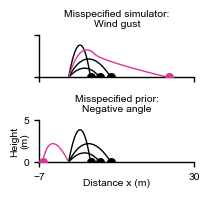

In [20]:
misspec_color = "#dd3497"

with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(2, 1, figsize=(2.0, 1.65))
    for xs, ys in zip(all_xs, all_ys):
        for i in range(2):
            _ = ax[1-i].plot(xs, ys, c="k")
            
    _ = ax[1-0].plot(missped_prior_all_xs[0], missped_prior_all_ys[0], c=misspec_color)
    _ = ax[1-1].plot(missped_sim_all_xs[0], missped_sim_all_ys[0], c=misspec_color)
    _ = ax[1-0].scatter(missped_prior_dists[0], [0.0], s=30.0, c=misspec_color, zorder=1000)
    _ = ax[1-1].scatter(missped_sim_dists[0], [0.0], s=30.0, c=misspec_color, zorder=1000)
    
    _ = ax[1-0].set_xlim([-7, 30])
    _ = ax[1-0].set_xticks([-7, 30])
    _ = ax[1-1].set_xlim([-7, 30])
    _ = ax[1-1].set_xticks([-7, 30])
    for i in range(2):
        _ = ax[1-i].set_ylim([0, 5])
        _ = ax[1-i].set_yticks([0, 5])
        _ = ax[1-i].set_xlabel("Distance x (m)", labelpad=-2)
        _ = ax[1-i].set_ylabel("Height\n(m)", labelpad=-4)
        for dist in dists:
            _ = ax[1-i].scatter([dist], [0.0], s=30.0, c="k", zorder=1000)
#     plt.savefig("svg/panel_a.svg", bbox_inches="tight", transparent=True)
#     plt.savefig("png/panel_a.png", dpi=300, bbox_inches="tight", transparent=True)
    _ = ax[1-0].set_title("Misspecified prior:\nNegative angle")
    _ = ax[1-1].set_title("Misspecified simulator:\nWind gust")
    _ = ax[0].set_ylabel("")
    _ = ax[0].set_yticklabels([])
    _ = ax[0].set_xticklabels([])
#     _ = ax[0].set_xticklabels([])
    _ = ax[0].set_xlabel("")
    plt.subplots_adjust(hspace=1.0)
    plt.savefig("svg/panel_a_misspec.svg", bbox_inches="tight", transparent=True)
    plt.show()

### Inference

In [118]:
prior_angle = MultivariateNormal(35 * torch.ones((1,)), 15**2 * torch.eye(1))
prior = prior_angle
latent = Exponential(200.0 * torch.ones((1,)))
friction = 0.1
dt = 0.5

# Train

In [64]:
num_sims = 10_000

theta = prior.sample((num_sims,))
z = latent.sample((num_sims,))
x = []
for t, zz in zip(theta, z):
    trace = simulate(t.item(), 2.0, zz.item())
    dist = throw_distance(*trace)
    x.append(dist)

x = torch.as_tensor(x, dtype=float32).unsqueeze(1)

In [65]:
_ = torch.manual_seed(0)
inference = NPE(prior=prior, density_estimator="nsf")
_ = inference.append_simulations(theta, x).train(max_num_epochs=200)

 Neural network successfully converged after 82 epochs.

In [67]:
posterior = inference.build_posterior()

In [14]:
x_o_val = 13.0
x_axis = torch.linspace(0, 90, 100).unsqueeze(1)
probs = posterior.log_prob(x_axis, x=torch.as_tensor([[x_o_val]])).exp().numpy()

with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.7, 1.7))
    _ = ax.scatter(theta[:500, 0].numpy(), x[:500, 0].numpy(), s=2.0, c="k")
    _ = ax.set_xticks([0, 90])
    _ = ax.set_xlim([0, 90])

    _ = ax.set_yticks([-5.5, 0, 20, 26.5])
    _ = ax.set_yticklabels([r"$x_o$", 0, 20, r"$x_o$"])
    _ = ax.set_ylim([-10, 35])
    _ = ax.axhline(-5.5, c=misspec_color)
    _ = ax.axhline(26.5, c=misspec_color)
    _ = ax.set_xlabel("Angle " + r"$\theta$", labelpad=-2)
    _ = ax.set_ylabel("Distance x")
    _ = ax.set_title("Joint distribution", pad=11)
    plt.savefig("svg/panel_b_misspec.svg", bbox_inches="tight", transparent=True)
    plt.show()

NameError: name 'posterior' is not defined

In [21]:
import time
import IPython.display as IPd
from svgutils.compose import *

def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_bold = {'size': '10pt', 'font': 'Arial', 'weight': '800'}
kwargs_text = {'size': '7pt', 'font': 'Arial'}

f = Figure("9.2cm", "4.4cm",
    Text("a", 0, 10, **kwargs_bold),
    Panel(SVG("svg/panel_a_misspec.svg").scale(svg_scale)).move(-6, -6),
    Text("b", 190, 10, **kwargs_bold),
    Panel(SVG("svg/panel_b_misspec.svg").scale(svg_scale)).move(180, -6),
)

!mkdir -p fig
f.save("fig/fig2_misspec.svg")
svg("fig/fig2_misspec.svg")